<div align="center">

  <a href="https://clear.ml" target="_blank">
    <img width="512", src="https://github.com/allegroai/clearml/raw/master/docs/clearml-logo.svg"></a>


<br>

<h1>Notebook 1: Experiment Management</h1>

<br>

Hi there! This is the ClearML getting started notebook, meant to teach you the ropes. ClearML has a lot of modules that you can use, so in this notebook, we'll start with the most well-known one: <a href="https://app.clear.ml/projects" target="_blank">Experiment Management.</a>

You can find out more details about the other ClearML modules and the technical specifics of each in <a href="https://clear.ml/docs" target="_blank">our documentation.</a>


<table>
<tbody>
  <tr>
    <td><b>Step 1: Experiment Management</b></td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_1_Experiment_Management.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
  <tr>
    <td>Step 2: Remote Agent</td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_2_Setting_Up_Agent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
  <tr>
    <td>Step 3: Remote Task Execution</td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_3_Remote_Execution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
</tbody>
</table>

</div>

# 📦 Setup

Since we are using a notebook here, we're importing the special `browser_login` function, it will try to help you easily log in. If it doesn't work, don't worry, it will guide you through the steps to get it done :)

**If it asks you to generate new credentials, keep them handy, you'll need them again in later notebooks**

When installing ClearML in a normal python environment (not a colab notebook), you'll want to use `clearml-init` instead. It, too, will guide you through the setup.

What we're doing here is connecting to a ClearML server, that will store all your experiment details.

In [ ]:
%pip install --upgrade xgboost clearml
import clearml
clearml.browser_login()

# ✈️ Example: XGBoost

Let's start simple, by adding the ClearML experiment tracker to an XGBoost training script.

The important parts are:

- Initializing ClearML. Always do this as a very first line if possible!
- Manually log the parameter dict (e.g. CLI commands are captured automatically)

**⚠️ NOTE: `output_uri` in `Task.init` is an important parameter. By default it is set to `False`, meaning any registered models will NOT be uploaded to ClearML, but their info will be registered. Set this to `True` to automatically upload all model files.**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from clearml import Task
import xgboost as xgb
import numpy as np


# Always initialize ClearML before anything else. Automatic hooks will track as
# much as possible for you!
task = Task.init(
    project_name="Getting Started",
    task_name="XGBoost Training",
    output_uri=True  # IMPORTANT: setting this to True will upload the model
    # If not set the local path of the model will be saved instead!
)

# Training data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Setting the parameters
params = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'reg:squarederror',
    'nthread': 4,
    'eval_metric': 'rmse',
}
# Make sure ClearML knows these parameters are our hyperparameters!
task.connect(params)

# Train the model
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=0,
)

# Save the model, saving the model will automatically also register it to 
# ClearML thanks to the automagic hooks
bst.save_model("best_model")

ClearML Task: created new task id=38ba982031b04187a59acbd7346c5010
ClearML results page: https://app.clear.ml/projects/df7858a441f94c29a1230d467f131840/experiments/38ba982031b04187a59acbd7346c5010/output/log
2023-03-06 16:06:09,239 - clearml.Task - INFO - Storing jupyter notebook directly as code


In [ ]:
# When a python script ends, the ClearML task is closed automatically. But in
# a notebook (that never ends), we need to manually close the task.
task.close()

## 🔹 XGBoost WebUI


After running the code above you should have a new ClearML project on your server called "Getting Started".

Inside the task, a lot of things are tracked!



### Source information (git, installed packages, uncommitted changes, ...)

Naturally, running this notebook doesn't actually give us any git information. Instead ClearML saves the execution order of the cells you've executed until it detected the `Task.close()` command.

![](https://i.imgur.com/DehMv2X.png)

### Configuration

The configuration section holds all the values we added using the `task.connect()` call before. You can also use `task.set_parameter()` for a single value or `task.connect_configuration()` to connect an external configuration file.

![](https://i.imgur.com/hlHcKfm.png)

### Artifacts


Artifacts are very flexible and can mean every type of file storage. Mostly this is used to track and save input and output models. In this case we get the saved XGBoost model. But when running a notebook you'll also get the original notebook here as well as an HTML preview!

![](https://i.imgur.com/Ow5meUZ.png)


### Scalars

Scalars are the performance values of your models. They can either be a value for each epoch/iteration, which will display them as a plot, or a single one, which displays them as a table. In our example above the scalars where automatically grabbed from XGBoost using our integration!

![](https://i.imgur.com/QBl79GI.png)


### Plots and Debug Samples

We haven't generated any plots or debug samples in our XGBoost example. We'll look at these a little later in the tutorial.


### Info + Console logs

These sections speak for themselves: you get some additional information (like runtime or original machine hostname) as well as the original console logs.




# 🚀 Example: Pytorch + Tensorboard + Matplotlib

As you might have seen, our previous example was missing plots and debug samples, none were logged to ClearML! Luckily, XGBoost is not the only integration that ClearML has, it can also lift scalars, plots and debug samples from other frameworks you most likely use already.

A full list of our integrations can be found [here](https://clear.ml/docs/latest/docs/integrations/libraries).

## 🔹 Logging scalars through Tensorboard

ClearML will detect this and also log scalars, images etc. to the ClearML experiment manager. So you don't even have to change your existing code!

![](https://i.imgur.com/4MNZdGi.png)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from clearml import Task
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter


# Always initialize ClearML before anything else. Automatic hooks will track as
# much as possible for you (such as in this case TensorBoard logs)!
task = Task.init(project_name="Getting Started", task_name="TB Logging")

# Set up TensorBoard logging
writer = SummaryWriter()

# Load MNIST dataset
train_data = MNIST('data', train=True, download=True, transform=ToTensor())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Define model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_loader):
        # Flatten input images
        inputs = inputs.view(-1, 784)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and update parameters
        loss.backward()
        optimizer.step()
        
        # Log loss to TensorBoard
        # ClearML will detect this and also log the scalar to the ClearML
        # experiment manager. So you don't even have to change your existing code!
        writer.add_scalar('Training loss', loss.item(), epoch * len(train_loader) + i)
        
    print(f'Epoch {epoch + 1} complete')
    
# Close TensorBoard writer
writer.close()

ClearML Task: created new task id=0bfefb8b86ba44798d9abe34ba0a6ab4
ClearML results page: https://app.clear.ml/projects/df7858a441f94c29a1230d467f131840/experiments/0bfefb8b86ba44798d9abe34ba0a6ab4/output/log
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete


## 🔹 Logging debug samples through matplotlib

Whenever you use `plt.imshow()` ClearML will intercept the call and immediately log the image to the experiment manager. The images will become visible under the Debug Samples tab.

![](https://i.imgur.com/FuHTPKP.png)

You can log basically any media type (images, videos, audio, ...) as a debug sample. Check [our docs](https://clear.ml/docs/latest/docs/references/sdk/logger#report_media) for more info.

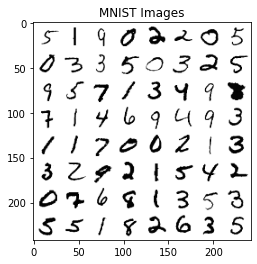

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title("MNIST Images")
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

## 🔹 Logging plots through Matplotlib

Similar to above, matplotlib is automatically captured, but this time, we use `plt.show()` (implicit inside `ConfusionMatrixDisplay`) which logs the result as a plot!

![](https://i.imgur.com/Q4H7RDM.png)



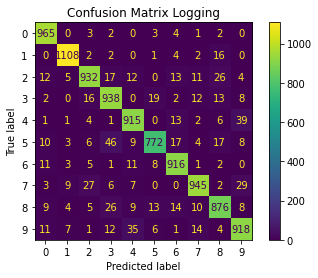

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Load MNIST test dataset
test_data = MNIST('data', train=False, download=True, transform=ToTensor())
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Test the model and compute confusion matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 784)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.title("Confusion Matrix Logging")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

In [ ]:
# When a python script ends, the ClearML task is closed automatically. But in
# a notebook (that never ends), we need to manually close the task.
task.close()

# 🚁 Example: Sklearn

As a third example, let's train an sklearn example. Here, too, ClearML will automatically capture a number of outputs, which we will describe in the code comments.

ClearML Task: created new task id=62fb0fc73d384181a220dfb8adb2c75a
ClearML results page: https://app.clear.ml/projects/df7858a441f94c29a1230d467f131840/experiments/62fb0fc73d384181a220dfb8adb2c75a/output/log


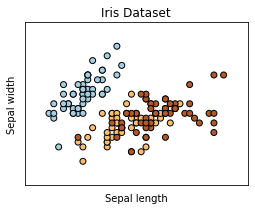

In [ ]:
import joblib

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from clearml import Task


# Connecting ClearML with the current process,
# from here on everything is logged automatically
task = Task.init(
    project_name="Getting Started",
    task_name="Scikit-Learn",
    output_uri=True
)

iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)

# Using joblib to save the model will automatically register it to ClearML, too!
joblib.dump(model, 'model.pkl', compress=True)

loaded_model = joblib.load('model.pkl')
result = loaded_model.score(X_test, y_test)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.figure(1, figsize=(4, 3))

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Iris Dataset")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

# Plt.show() will trigger ClearML to log the resulting plot automatically
plt.show()

# Always close the task when in a notebook! If using a python file, the task is
# closed automatically when the script ends.
task.close()

# ✋ Manual Logging

Naturally, when our integrations aren't cutting it for you, you can always manually log anything you wish!

Check our documentation for [a list of examples](https://clear.ml/docs/latest/docs/fundamentals/logger#explicit-reporting-examples) of how to manually log anything else!

# 🥾 Next Steps

Now that you have the basics of the experiment manager, take a look at **running this experiment remotely**! Start by setting up a remote agent and then clone and enqueue these experiments using the ClearML orchestration component.

The [second notebook](https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_2_Setting_Up_Agent.ipynb) in this series will get you started with this.

<table>
<tbody>
  <tr>
    <td>Step 1: Experiment Management</td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_1_Experiment_Management.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
  <tr>
    <td><b>NEXT UP -> Step 2: Remote Execution Agent Setup</b></td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_2_Setting_Up_Agent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
  <tr>
    <td>Step 3: Remotely Execute Tasks</td>
    <td><a target="_blank" href="https://colab.research.google.com/github/allegroai/clearml/blob/master/docs/tutorials/Getting_Started_3_Remote_Execution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></td>
  </tr>
</tbody>
</table>